# Deep Learning for Portfolio Optimization

Ver paper https://arxiv.org/pdf/2005.13665v3.pdf.


In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import tensorflow as tf

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import yfinance as yf

vti = yf.download("VTI", start="2015-1-1", end="2021-09-30")
agg = yf.download("AGG", start="2015-1-1", end="2021-09-30")
dbc = yf.download("DBC", start="2015-1-1", end="2021-09-30")
vixy = yf.download("VIXY", start="2015-1-1", end="2021-09-30")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
import pandas as pd 
import numpy as np

data = pd.concat([df.loc[:, "Adj Close"] for df in [vti, agg, dbc, vixy]], axis=1)

In [5]:
data.columns = ["VTI", "AGG", "DBC", "VIXY"]
data.head()

,VTI,AGG,DBC,VIXY
Date,,,,
2015-01-02,93.630058,93.813484,17.712509,1648.800049
2015-01-05,92.021255,94.017349,17.459890,1772.000000
2015-01-06,91.119591,94.255188,17.294714,1810.400024
2015-01-07,92.206879,94.238205,17.187840,1750.400024
2015-01-08,93.833374,94.093765,17.255852,1638.400024


In [6]:
returns = data.pct_change()[1:]

In [7]:
returns.shape

(1697, 4)

In [9]:
returns[:60].values.flatten().shape # Usamos los retornos de 60 dias en el pasado como features. Hay que hacer flatten
                                    # para poder darselos de input a la red.

(240,)

In [10]:
def build_model(input_shape, outputs, returns):

    returns_tf = tf.cast(tf.constant(returns), float)

    model = Sequential()

    model.add(
        Dense(
            20,
            activation="relu",
            batch_input_shape=(None, input_shape)
        )
    )

    model.add(
        Dense(
            20,
            activation="relu",
        )
    )

    model.add(
        Dense(
        outputs, 
            activation="softmax" # Necesitamos softmax porque los pesos deben sumar 1
        )
    )
    
    @tf.function
    def sharpe_loss(_, y_pred):

        portfolio_returns = tf.reduce_sum(tf.multiply(returns_tf, y_pred), axis=1)

        sharpe = tf.keras.backend.mean(portfolio_returns) / tf.keras.backend.std(portfolio_returns)
        
        return -sharpe

    model.compile(loss=sharpe_loss, optimizer="adam")

    return model

In [77]:
lookback_period = 60
model = build_model(returns[:lookback_period].values.flatten().shape[0], len(data.columns), returns[:lookback_period])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                4820      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 84        
Total params: 5,324
Trainable params: 5,324
Non-trainable params: 0
_________________________________________________________________


In [14]:
returns[:lookback_period].values.flatten()[np.newaxis, :].shape

(1, 240)

In [57]:
history = model.fit(
    returns[:lookback_period].values.flatten()[np.newaxis, :], 
    np.zeros((1, len(returns.columns))), epochs=150, shuffle=False, verbose=0
    )

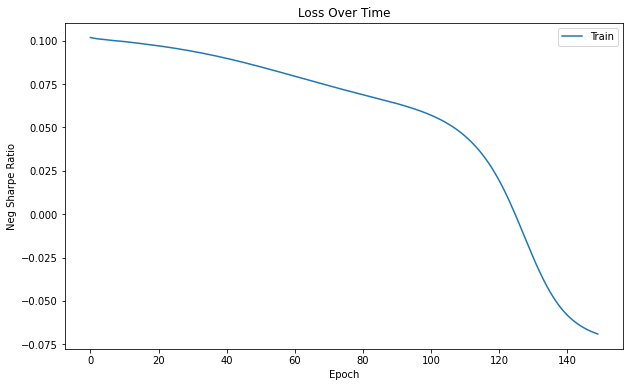

In [58]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(history.history["loss"], label="Train")
ax.set_xlabel("Epoch")
ax.set_ylabel("Neg Sharpe Ratio")
ax.set_title("Loss Over Time")
ax.legend()

In [18]:
model.predict(tf.constant(returns[:lookback_period].values.flatten()[np.newaxis, :], float))[0]

array([7.6857759e-03, 9.9102217e-01, 8.7440043e-05, 1.2046604e-03],
      dtype=float32)

In [79]:
from tqdm import tqdm


rebalance_period = 15

weights = []

portfolio_return = []

input_shape = returns[:lookback_period].values.flatten().shape[0]

outputs = len(data.columns)

for i in tqdm(range(lookback_period, returns.shape[0])):
    
    if i % rebalance_period == 0:
        
        ret = returns.iloc[i-60:i]
        
        model = build_model(
            input_shape, 
            outputs, 
            ret
        )

        history = model.fit(
            ret.values.flatten()[np.newaxis, :], 
            np.zeros((1, len(returns.columns))), 
            epochs=150, 
            shuffle=False, 
            verbose=0
        )

        w = model.predict(tf.constant(ret.values.flatten()[np.newaxis, :], float))[0]

        weights.append(w)

    else:

        weights.append(weights[-1])

    portfolio_return.append((weights[-1]*returns.iloc[i]).sum())

  2%|▏         | 31/1637 [00:02<02:15, 11.86it/s]

  3%|▎         | 46/1637 [00:03<01:56, 13.63it/s]

100%|██████████| 1637/1637 [01:57<00:00, 13.96it/s]


In [80]:
len(weights)

1637

In [81]:
weights = pd.DataFrame(weights, columns=returns.columns, index=returns.index[60:])

In [86]:
portfolio_return = pd.Series(portfolio_return, index=returns.index[60:])
print("Cumulative return:")
print((portfolio_return + 1.).cumprod().iloc[-1])

Cumulative return:
1.611723282270923


In [83]:
weights = weights.stack().reset_index().rename({'level_1': 'ETF', 0: 'weight'}, axis=1)

In [84]:
import altair as alt
alt.data_transformers.disable_max_rows()

alt.Chart(weights).mark_area().encode(
    x="Date:T",
    y="weight:Q",
    color="ETF:N"
)

alt.Chart(...)

In [88]:
print("Annualized mean return:")
print(portfolio_return.mean()*252)

Annualized mean return:
0.08825075432848983


In [89]:
print("Annualized volatility:")
print(portfolio_return.std()*np.sqrt(252))

Annualized volatility:
0.1731018051283477


In [87]:
print("Sharpe Ratio:")
print(portfolio_return.mean()*252 / (portfolio_return.std()*np.sqrt(252)))

Sharpe Ratio:
0.5098199540036894
